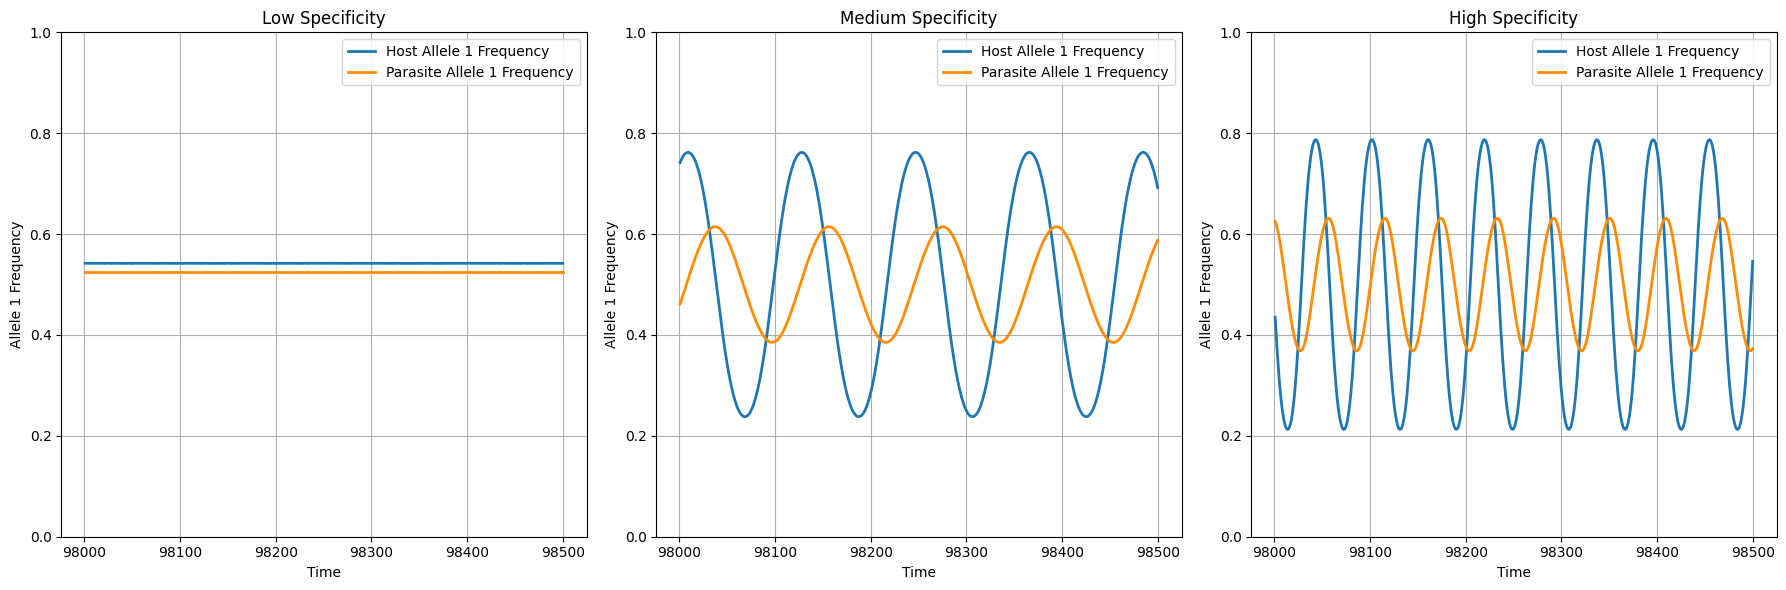

In [2]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Define parameters
d = 0.1          # Natural death rate
q = 0.5          # Competition coefficient
gamma = 0.125    # Recovery rate
theta = 0.1      # Parasite production rate
delta = 0.05     # Parasite clearance rate

# Virulence trait alpha (since we have only one trait)
alpha = 0.2      # You can adjust this value as needed

# Define the infection matrix Q as a function of specificity parameter s
def create_infection_matrix(s):
    N = 2
    Q = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            if i == j:
                Q[i, j] = 1 + (N-1)*s
            else:
                Q[i, j] = 1 - s
    return Q

# Birth rate function
def b(i):
    return 1.0

# Define the system of differential equations
def dydt(t, y, s):
    # Unpack state variables
    S1, S2, I11, I12, I21, I22, P1, P2 = y

    # Compute total population
    totalPopulation = S1 + S2 + I11 + I12 + I21 + I22

    # Calculate alpha_sqrt
    alpha_sqrt = np.sqrt(alpha)

    # Get the Q matrix for the current specificity level
    Q = create_infection_matrix(s)

    # Infection terms
    infectionS1 = alpha_sqrt * (Q[0, 0] * P1 * S1 + Q[0, 1] * P2 * S1)
    infectionS2 = alpha_sqrt * (Q[1, 0] * P1 * S2 + Q[1, 1] * P2 * S2)
    recoveryS1 = gamma * (I11 + I12)
    recoveryS2 = gamma * (I21 + I22)

    # Derivatives
    dS1_dt = b(1) * S1 * (1 - q * totalPopulation) - d * S1 - infectionS1 + recoveryS1
    dS2_dt = b(2) * S2 * (1 - q * totalPopulation) - d * S2 - infectionS2 + recoveryS2

    dI11_dt = Q[0, 0] * alpha_sqrt * P1 * S1 - (d + gamma + alpha) * I11
    dI12_dt = Q[0, 1] * alpha_sqrt * P2 * S1 - (d + gamma + alpha) * I12
    dI21_dt = Q[1, 0] * alpha_sqrt * P1 * S2 - (d + gamma + alpha) * I21
    dI22_dt = Q[1, 1] * alpha_sqrt * P2 * S2 - (d + gamma + alpha) * I22

    dP1_dt = theta * (I11 + I21) - delta * P1
    dP2_dt = theta * (I12 + I22) - delta * P2

    return [dS1_dt, dS2_dt, dI11_dt, dI12_dt, dI21_dt, dI22_dt, dP1_dt, dP2_dt]

# Initial conditions
constantFactor = 10
S1_0 = 0.9 * constantFactor
S2_0 = 0.85 * constantFactor
I11_0 = 0.1 * constantFactor
I12_0 = 0.08 * constantFactor
I21_0 = 0.065 * constantFactor
I22_0 = 0.07 * constantFactor
P1_0 = 0.1 * constantFactor
P2_0 = 0.09 * constantFactor

y0 = [S1_0, S2_0, I11_0, I12_0, I21_0, I22_0, P1_0, P2_0]

# Time span for the simulation
t_span = [90000, 100000]  # From time 2000 to 10000
t_eval = np.linspace(t_span[0], t_span[1], 10000)  # 10000 time points for evaluation

# Values of s to simulate
s_values = [0, 0.5, 1]

# Set up the figure and axes
fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns

titles = [
    'Low Specificity', 
    'Medium Specificity', 
    'High Specificity'
]

for idx, s in enumerate(s_values):
    # Solve the ODE system
    sol = solve_ivp(lambda t, y: dydt(t, y, s), t_span, y0, t_eval=t_eval, method='RK45')

    # Extract solutions
    S1 = sol.y[0]
    S2 = sol.y[1]
    I11 = sol.y[2]
    I12 = sol.y[3]
    I21 = sol.y[4]
    I22 = sol.y[5]
    P1 = sol.y[6]
    P2 = sol.y[7]
    time = sol.t

    # Calculate allele frequencies
    host_frequency = (S1 + I11 + I12) / (S1 + S2 + I11 + I12 + I21 + I22)
    parasite_frequency = P1 / (P1 + P2)

    x = 8000
    y = 8500

    # Plot host and parasite allele frequencies
    axs[idx].plot(time[x:y], host_frequency[x:y], label='Host Allele 1 Frequency', linewidth=2)
    axs[idx].plot(time[x:y], parasite_frequency[x:y], label='Parasite Allele 1 Frequency', color='darkorange', linewidth=2)
    axs[idx].set_xlabel('Time')
    axs[idx].set_ylabel('Allele 1 Frequency')
    axs[idx].set_title(titles[idx])
    axs[idx].grid(True)

    # Set y-axis limits from 0 to 1
    axs[idx].set_ylim(0, 1)

# Add legends
for ax in axs:
    ax.legend(loc='upper right')

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig('time_series_plot.png', dpi=500)
plt.show()